# <center><b><font color='blue'>Bitcoin Price Prediction</font></b></center>

<a name="1"></a>
## 1. Objetivos

Aprender acerca de las series temporales.

<a name="2"></a>
## 2. Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime
from sklearn.preprocessing import minmax_scale

<a name="3"></a>
## 3. Helper Functions

In [30]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)


    
# se implementa MASE pues no existe en TF
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season
    
    
    
# make predictions
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions



# Evaluaci[on  de predicciones

# Create a function to take in model predictions and truth values and return evaluation metrics
# sirve para horizonte largo 1
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds_general(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}




# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    
    Recine arreglos de numpy
    Devuelve arreglos de numpy
    
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# create windowed dataset
def create_windowed_dataset(dataset,window_size):
    """
    dataset: a dataset with a key "price"
    window size
    """
    # Make a copy of the Bitcoin historical data with block reward feature
    dataset_windowed = dataset.copy()
    # Add windowed columns
    for i in range(window_size): # shift values for each step in WINDOW_SIZE
        dataset_windowed[f"Price+{i+1}"] = dataset_windowed["Price"].shift(periods=i+1)
        
    
    # drop nan values
    dataset_windowed.dropna(inplace=True)
    
    # convert to float32
    #dataset_windowed["Price"] = dataset_windowed["Price"].astype(np.float32)
    
    dataset_windowed = dataset_windowed.astype(np.float32)

    # return
    return dataset_windowed

<a name="4"></a>
## 4. Carga y pre-procesamiento de datos

In [5]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [31]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [32]:
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


#### Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [33]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [34]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [35]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [36]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


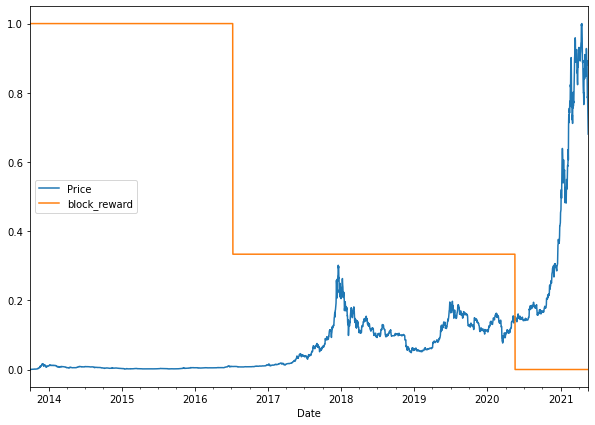

In [37]:
# Plot the block reward vs price over time
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

#### Construyamos el windowed dataset

In [38]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [39]:
bitcoin_windowed = create_windowed_dataset(bitcoin_prices_block,WINDOW_SIZE)
bitcoin_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-08,123.032997,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,124.049004,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,125.961159,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,125.279663,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,125.927498,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [40]:
# Create X (windows) and y (horizons) features
X = bitcoin_windowed.drop("Price", axis=1)
y = bitcoin_windowed["Price"]

In [41]:
X_train, X_test, y_train, y_test = make_train_test_splits(X.values, y.values)
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Modelo

In [42]:
type(X_train),type(X_test),type(y_test),type(y_train)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [43]:
def build_model(horizon,name):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(horizon)
    ],name=name)
    return model
    
    
model = build_model(HORIZON,"model_dense_multivariate")    


# Compile
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/100
18/18 [==============================] - 2s 40ms/step - loss: 2178.7771 - val_loss: 917.7772
Epoch 2/100
18/18 [==============================] - 0s 16ms/step - loss: 345.0782 - val_loss: 1860.8159
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 200.0420 - val_loss: 1085.1738
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 161.9886 - val_loss: 951.6896
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 153.7991 - val_loss: 870.2193
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 150.1477 - val_loss: 877.0585
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 147.7299 - val_loss: 900.4992
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 146.2541 - val_loss: 802.3000
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 140.4664 - val_loss: 803.0450
Epoch 10/100
18/18 [==============================] - 0s 10ms

18/18 [==============================] - 0s 10ms/step - loss: 108.4408 - val_loss: 684.2289
Epoch 80/100
18/18 [==============================] - 0s 10ms/step - loss: 111.5519 - val_loss: 566.8585
Epoch 81/100
18/18 [==============================] - 0s 11ms/step - loss: 110.1619 - val_loss: 607.2872
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 109.7119 - val_loss: 561.6622
Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 106.7779 - val_loss: 636.7526
Epoch 84/100
18/18 [==============================] - 0s 11ms/step - loss: 110.6170 - val_loss: 587.4020
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 111.1758 - val_loss: 596.1392
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 113.3390 - val_loss: 610.6765
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 112.6526 - val_loss: 653.7194
Epoch 88/100
18/18 [==============================] - 0s 10ms/step -

In [44]:
# Evaluate multivariate model
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 624.3812


624.3811645507812

In [45]:
# Make predictions with multivariate model
model_preds = tf.squeeze(model.predict(X_test))
model_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8978.462, 8902.477, 9170.345, 8906.753, 8875.899, 8869.063,
       8814.916, 8630.73 , 8595.781, 8652.054], dtype=float32)>

In [47]:
# Evaluate predictions to get eval metrics
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 624.3813,
 'mse': 1279712.2,
 'rmse': 1131.2437,
 'mape': 2.8916721,
 'mase': 1.0968649}